In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
import sys
from tqdm.auto import tqdm
import pandas as pd
import networkx as nx

In [3]:
project_root = os.path.abspath(
    os.path.join("C:/Users/jllgo/OneDrive/Documentos/UFMG/MSc & MSI 2/MatchSegmentation")
)
if project_root not in sys.path:
    sys.path.append(project_root)

In [4]:
from src.pass_networks.process_intervals import load_graphs
from src.pass_networks.pass_network import calculate_metrics 
from src.pass_networks.custom_metrics import calculate_average_path_legth_target
from src.pass_networks.custom_metrics import calculate_ffl
from src.pass_networks.custom_metrics import calculate_simrank
from src.pass_networks.custom_metrics import calculate_wasserstein_distance
from src.pass_networks.custom_metrics import calculate_modularity
from src.pass_networks.custom_metrics import calculate_graph_distance_stream

# Get Graphs

In [5]:
PROCESSED_DATA_PATH = "../data/processed/PL-22-23"
CSV_DATA_PATH = "../data/csv"

In [6]:
games = os.listdir(PROCESSED_DATA_PATH)
game_ids = [game.split('.')[0] for game in games]
print(f"Games to process: {len(game_ids)}")

Games to process: 190


In [7]:
matches = []

for match_id in tqdm(game_ids, desc="Loading Pre-Processed Graphs", total=len(game_ids)):
    match_graphs = load_graphs(match_id, PROCESSED_DATA_PATH)
    matches.append((match_id,match_graphs))

Loading Pre-Processed Graphs:   0%|          | 0/190 [00:00<?, ?it/s]

In [8]:
matches[0][1][-5:]

[{'2': <networkx.classes.digraph.DiGraph at 0x2673d5e68a0>,
  '7': <networkx.classes.digraph.DiGraph at 0x2673d5e68d0>},
 {'7': <networkx.classes.digraph.DiGraph at 0x2673d5e6900>},
 {'2': <networkx.classes.digraph.DiGraph at 0x2673d5e6930>,
  '7': <networkx.classes.digraph.DiGraph at 0x2673d5e6960>},
 {'7': <networkx.classes.digraph.DiGraph at 0x2673d5e6990>},
 {'2': <networkx.classes.digraph.DiGraph at 0x2673d5e69c0>,
  '7': <networkx.classes.digraph.DiGraph at 0x2673d5e69f0>}]

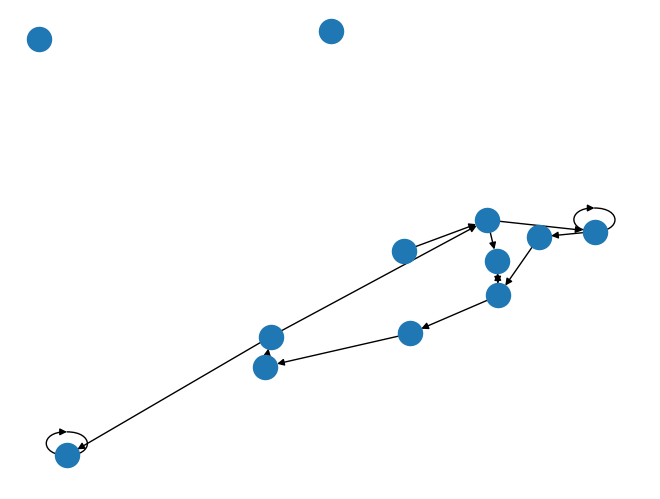

In [9]:
G = matches[0][1][0]['2']
G1 = matches[0][1][1]['7']
nx.draw(G)

# Graph Stream

In [10]:
selected_metrics = {
    "Density": nx.density,
    "Average Clustering": nx.average_clustering,
    "Betweenness Centrality": nx.betweenness_centrality,
    "Closeness Centrality": nx.closeness_centrality,
    "Averge Path Length": calculate_average_path_legth_target,
}

In [11]:
distance_metrics = {    
    #"GED": nx.graph_edit_distance,
    #"SimRank": calculate_simrank,
    "Wasserstein": calculate_wasserstein_distance
}

In [12]:
matches[0][1][0]['2'].nodes

NodeView((-1, 35, 9, 34, 11, 7, 1, 5, 8, 6, 12, 4))

In [22]:
match_graphs = matches[0][1]
count = sum(1 for interval in match_graphs if '2' in interval.keys())
count

41

In [31]:
streams = []

for match_id, grafos_por_intervalo in tqdm(matches[:1], desc="Calculating Metrics", total=len(matches)):
    # Estrutura para armazenar grafos e métricas organizados por equipe
    grafos = {}
    metricas = {}
    distancias = {}

    # Iterar sobre os intervalos de tempo (listas de grafos)
    for intervalo in tqdm(grafos_por_intervalo, desc=f"Processing Match {match_id}"):
        for equipe_id, grafo in intervalo.items():
            # Inicializar listas para cada equipe, se ainda não existirem
            if equipe_id not in grafos:
                grafos[equipe_id] = []
                metricas[equipe_id] = []

            # Adicionar o grafo ao intervalo correspondente da equipe
            grafos[equipe_id].append(grafo)

            # Adicionar métricas calculadas para o grafo
            metricas[equipe_id].append(calculate_metrics(grafo, selected_metrics))

    # Calcular distâncias entre os grafos de intervalos consecutivos
    for equipe_id, intervalos in tqdm(grafos.items(), desc="Calculating Distances", total=len(grafos)):
        distancias[equipe_id] = {}
        for metric_name, metric_fn in tqdm(distance_metrics.items(), desc="Calculating Distances", total=len(distance_metrics)):
            distancias[equipe_id][metric_name] = calculate_graph_distance_stream(intervalos, metric_name)

    # Adicionar os dados transformados ao resultado final
    streams.append({
        "match_id": match_id,
        "grafos": grafos,
        "metrics": metricas,
        "distances": distancias
    })

print(f"Generated {len(streams)} Graph Streams")

Calculating Metrics:   0%|          | 0/190 [00:00<?, ?it/s]

Processing Match 4436:   0%|          | 0/47 [00:00<?, ?it/s]

Calculating Distances:   0%|          | 0/2 [00:00<?, ?it/s]

Calculating Distances:   0%|          | 0/1 [00:00<?, ?it/s]

Calculando Wasserstein:   0%|          | 0/40 [00:00<?, ?it/s]

Calculating Distances:   0%|          | 0/1 [00:00<?, ?it/s]

Calculando Wasserstein:   0%|          | 0/44 [00:00<?, ?it/s]

Generated 1 Graph Streams


In [135]:
len(streams[0]['grafos']['7']),len(streams[0]['metrics']['7']),len(streams[0]['distances']['7']['Wasserstein'])

(45, 45, 44)

In [40]:
stream1 = streams[0]['distances']['2']['Wasserstein']
stream2 = streams[0]['distances']['7']['Wasserstein']
stream1

[np.float64(1.0),
 np.float64(2.4999999999999996),
 np.float64(1.9999999999999996),
 np.float64(0.6666666666666666),
 np.float64(0.6666666666666667),
 np.float64(0.8333333333333335),
 np.float64(0.16666666666666674),
 np.float64(1.1666666666666665),
 np.float64(0.5),
 np.float64(1.0),
 np.float64(0.33333333333333337),
 np.float64(1.3333333333333335),
 np.float64(1.8333333333333335),
 np.float64(1.3333333333333333),
 np.float64(0.33333333333333337),
 np.float64(0.5),
 np.float64(1.3333333333333335),
 np.float64(0.6666666666666666),
 np.float64(0.8333333333333333),
 np.float64(1.5),
 np.float64(0.5),
 np.float64(0.16666666666666669),
 np.float64(0.6666666666666667),
 np.float64(1.8333333333333335),
 np.float64(1.8333333333333335),
 np.float64(0.16666666666666663),
 np.float64(0.16666666666666674),
 np.float64(1.166666666666667),
 np.float64(0.6666666666666666),
 np.float64(0.5),
 np.float64(1.6666666666666667),
 np.float64(0.6666666666666666),
 np.float64(0.33333333333333337),
 np.float6

In [119]:
stream3 = np.average([stream1, stream2[:len(stream1)]], axis=0)
stream4 = np.sum([stream1, stream2[:len(stream1)]], axis=0)
stream3

array([0.66666667, 2.08333333, 1.16666667, 0.58333333, 0.66666667,
       0.5       , 0.16666667, 1.41666667, 0.83333333, 1.25      ,
       0.5       , 1.08333333, 2.41666667, 2.25      , 0.41666667,
       0.5       , 1.58333333, 1.        , 0.58333333, 0.91666667,
       0.58333333, 0.91666667, 1.33333333, 1.16666667, 1.83333333,
       0.41666667, 0.51282051, 1.34615385, 0.83333333, 0.75      ,
       1.5       , 0.91666667, 0.58333333, 0.75      , 0.58333333,
       1.        , 2.41666667, 2.16666667, 0.25      , 0.58333333])

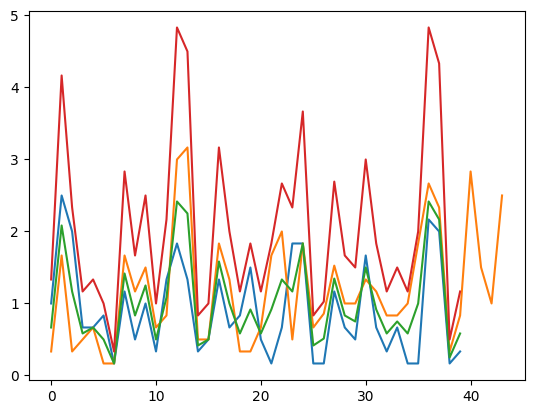

In [120]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(stream1)
plt.plot(stream2)
plt.plot(stream3)
plt.plot(stream4)
plt.show()

# Concept Drift

In [108]:
from src.concept_drift.drift_points import detect_kswin_drift

In [132]:
points = detect_kswin_drift(stream4,  a=0.35,ws=7,ss=3)
points

[9, 24, 37]

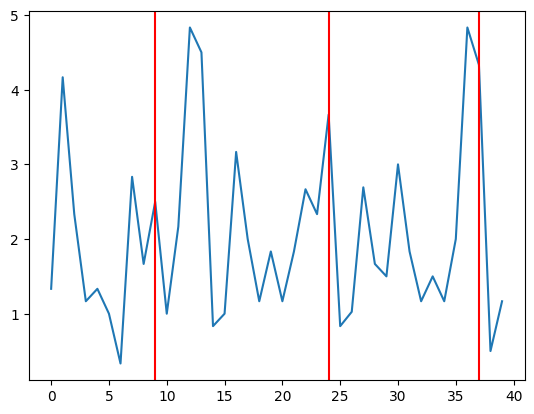

In [133]:
plt.plot(stream4)
for point in points:
    plt.axvline(x=point, color='r')
plt.show()